# **YOLOv8 - PPE DETECTION**

## **ENVIRONMENT SETTINGS**

**Install packages**

In [ ]:
# !pip install ultralytics==8.2.103
# !pip install roboflow==1.1.49
# !pip install comet_ml==3.47.4
# !pip install onnx==1.17.0
# !pip install onnxslim==0.1.34
# !pip install onnxruntime==1.20.1
# !pip install onnxruntime-gpu==1.20.1
# !pip install tensorrt==10.7.0
# !pip install py-cpuinfo
# !pip install psutil
# !pip install gputil

**Import libraries**

In [1]:
# Import libraries
import comet_ml
import cpuinfo
import glob
import GPUtil
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import psutil
import random
import roboflow
import seaborn as sns
import shutil
import subprocess
import torch
import urllib.request
import yaml

from PIL import Image
from ultralytics import YOLO

In [2]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4034MiB)
Setup complete ✅ (8 CPUs, 7.6 GB RAM, 69.0/294.2 GB disk)


**Machine specifications**

In [3]:
def print_machine_specs():
  # Operating System
  print("Operating System:")
  print(f"  Name: {platform.system()} {platform.release()}")
  print(f"  Version: {platform.version()}")
  print(f"  Processor: {platform.processor()}")
  print(f"  Architecture: {platform.architecture()[0]}\n")

  # OS - Distribution
  print("OS - Distribution:")
  print(f"  pretty name: {platform.freedesktop_os_release()['PRETTY_NAME']}")
  print(f"  name: {platform.freedesktop_os_release()['NAME']}")
  print(f"  version: {platform.freedesktop_os_release()['VERSION']}")
  print(f"  version codename: {platform.freedesktop_os_release()['VERSION_CODENAME']}")
  print(f"  id: {platform.freedesktop_os_release()['ID']}")
  print(f"  id like: {platform.freedesktop_os_release()['ID_LIKE']} \n")

  # CPU Information
  cpu = cpuinfo.get_cpu_info()
  print("CPU Information:")
  print(f"  Processor: {cpu['brand_raw']}")
  print(f"  Cores: {psutil.cpu_count(logical=False)}")
  print(f"  Threads: {psutil.cpu_count(logical=True)}")
  print(f"  Max Frequency: {psutil.cpu_freq().max:.2f} MHz\n")

  # Memory Information
  virtual_memory = psutil.virtual_memory()
  print("Memory Information:")
  print(f"  Total: {virtual_memory.total / (1024 ** 3):.2f} GB")
  print(f"  Available: {virtual_memory.available / (1024 ** 3):.2f} GB\n")

  # Disk Information
  disk_usage = psutil.disk_usage('/')
  print("Disk Information:")
  print(f"  Total: {disk_usage.total / (1024 ** 3):.2f} GB")
  print(f"  Used: {disk_usage.used / (1024 ** 3):.2f} GB")
  print(f"  Free: {disk_usage.free / (1024 ** 3):.2f} GB\n")

  # GPU Information (if available)
  try:
    gpus = GPUtil.getGPUs()
    print("GPU Information:")
    for gpu in gpus:
      print(f"  GPU: {gpu.name}")
      print(f"  Memory Total: {gpu.memoryTotal} MB")
      print(f"  Memory Free: {gpu.memoryFree} MB")
      print(f"  Memory Used: {gpu.memoryUsed} MB\n")
  except ImportError:
    print("GPU Information: GPUtil not installed. Install it using `pip install gputil`.\n")

  # Python Information
  print("Python Environment:")
  print(f"  Version: {platform.python_version()}")
  print(f"  Compiler: {platform.python_compiler()}\n")

print_machine_specs()

Operating System:
  Name: Linux 6.8.0-51-generic
  Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
  Processor: x86_64
  Architecture: 64bit

OS - Distribution:
  pretty name: Ubuntu 22.04.5 LTS
  name: Ubuntu
  version: 22.04.5 LTS (Jammy Jellyfish)
  version codename: jammy
  id: ubuntu
  id like: debian 

CPU Information:
  Processor: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz
  Cores: 4
  Threads: 8
  Max Frequency: 4000.00 MHz

Memory Information:
  Total: 7.61 GB
  Available: 2.76 GB

Disk Information:
  Total: 294.23 GB
  Used: 53.99 GB
  Free: 225.22 GB

GPU Information:
  GPU: NVIDIA GeForce GTX 1050 Ti
  Memory Total: 4096.0 MB
  Memory Free: 4031.0 MB
  Memory Used: 4.0 MB

Python Environment:
  Version: 3.12.7
  Compiler: GCC 11.2.0



**Graphics card features**

In [3]:
# Verify cuda available device
cuda_device_num = torch.cuda.device_count()
if not cuda_device_num:
  print("\033[93m WARNING: No cuda devices found. \033[0m")
else:
  print(f"\033[34m INFO: There {'is' if cuda_device_num == 1 else 'are'} {cuda_device_num} pytorch cuda devices. \033[0m")
  print(f"\033[34m       Pyorch cuda version: {torch.version.cuda} \033[0m")
  print(f"\033[34m-\033[0m" * 35)
  for index in  range(cuda_device_num):
    print(f"\033[34m GPU {index}: {torch.cuda.get_device_name(index)} \033[0m")
    print(f"\033[34m \tTotal cuda device memory {torch.cuda.mem_get_info(0)[1] // 2 ** 20} MiB\033[0m")
    print(f"\033[34m \tFree cuda device memory {torch.cuda.mem_get_info(index)[0] // 2 ** 20} MiB\033[0m\n")

  print("Graphics card information")
  print(subprocess.check_output("nvidia-smi").decode())

 INFO: There is 1 pytorch cuda devices. 
       Pyorch cuda version: 12.4 
-----------------------------------
 GPU 0: NVIDIA GeForce GTX 1050 Ti 
 	Total cuda device memory 4034 MiB
 	Free cuda device memory 3986 MiB

Graphics card information
Mon Jan 27 18:40:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0 Off |           

**Directory structure**

In [4]:
# Run local or not
PROJ_ROOT = os.getcwd()
is_local = True if os.path.basename(PROJ_ROOT) == "notebooks" else False

# Directories path
if not is_local:
  os.makedirs("data", exist_ok=True)
  os.makedirs("models", exist_ok=True)
  os.makedirs("models/trained", exist_ok=True)
  data_relative_path ="data"
  models_relative_path = "models"
else:
  os.makedirs("../models/trained", exist_ok=True)
  data_relative_path ="../data/processed"
  models_relative_path = "../models"

PROCESSED_DATA_DIR = os.path.join(PROJ_ROOT, data_relative_path)
MODELS_DIR = os.path.join(PROJ_ROOT, models_relative_path)
TRAINED_MODEL_DIR = os.path.join(MODELS_DIR, "trained")

# Print processed data path
print(f"\033[34m INFO: Processed data in {PROCESSED_DATA_DIR} \033[0m")
print(f"\033[34m INFO: Models in {MODELS_DIR} \033[0m")
print(f"\033[34m INFO: Trained model in {TRAINED_MODEL_DIR} \033[0m")

 INFO: Processed data in -> /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed 
 INFO: Models in -> /home/harvey/Documents/yolo_ppe_detection/notebooks/../models 
 INFO: Trained model in -> /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained 


**Configuration variables**

In [5]:
# Configuration class
class CFG:
  # Clases
  CLASSES = ["hard_hat",
            "no_hard_hat",
            "no_safety_harness",
            "no_safety_vest",
            "person",
            "safety_harness",
            "safety_vest"]

  # Model
  MODEL_VERSION = "v8"
  MODEL_SIZE = "n" # n, s, m, l, x
  PRETRAINED = True
  MODEL_NAME = f"yolo{MODEL_VERSION}{MODEL_SIZE}"
  BASE_MODEL = f"{MODEL_NAME}.{'pt' if PRETRAINED else 'yaml'}"

  # Dataset settings (Roboflow)
  DATASET_WORKSPACE = "deeplearning-cwudo"
  DATASET_PROJECT = "yolo_ppe_detection"
  DATASET_FORMAT = "yolov8"
  DATASET_VERSION = 5
  DATASET_NAME = f"ppe_dataset_v{DATASET_VERSION}"
  DATASET_PATH = os.path.join(PROCESSED_DATA_DIR, DATASET_NAME)
  DATASET_YAML_PATH = os.path.join(DATASET_PATH, "data.yaml")

  # Train variables
  DEBUG = True
  EPOCHS = 3 if DEBUG else 500
  PATIENCE = 40
  FRACTION = 0.01 if DEBUG else 1.0
  TRAIN_DEVICE = 0 if cuda_device_num else "cpu"
  TRAIN_MODEL_PATH = os.path.join(MODELS_DIR, "base", BASE_MODEL) if PRETRAINED else BASE_MODEL
  TRAIN_PROJECT_NAME = f"train_{MODEL_NAME}_ppe_detection{'_debug' if DEBUG else ''}"
  TRAIN_PROJECT_PATH = os.path.join(MODELS_DIR, TRAIN_PROJECT_NAME)
  TRAIN_NAME = f"{'pt' if PRETRAINED else 'yaml'}_{EPOCHS}_epochs"

  # Valid variables
  VALID_DEVICE = "0" if cuda_device_num else "cpu"
  VALID_MODEL_PATH = os.path.join(TRAIN_PROJECT_PATH, TRAIN_NAME, "weights", "best.pt")
  VALID_PROJECT_NAME = f"valid_{MODEL_NAME}_ppe_detection{'_debug' if DEBUG else ''}"
  VALID_PROJECT_PATH = os.path.join(MODELS_DIR, VALID_PROJECT_NAME)
  VALID_NAME = f"{'pt' if PRETRAINED else 'yaml'}_{EPOCHS}_epochs"

  # Export variables
  EXPORT_FORMAT = "engine"
  EXPORT_MODEL_NAME = "ppe_detection.pt"
  EXPORT_DEVICE = "0" if cuda_device_num else "cpu"
  EXPORT_MODEL_PATH = os.path.join(TRAINED_MODEL_DIR, EXPORT_MODEL_NAME)

  # Predict variables
  PREDICT_DEVICE = "0" if cuda_device_num else "cpu"
  PREDICT_MODEL_NAME = "ppe_detection.engine"
  PREDICT_MODEL_PATH = os.path.join(TRAINED_MODEL_DIR, PREDICT_MODEL_NAME)
  PREDICT_PROJECT_NAME = f"predict_{MODEL_NAME}_ppe_detection{'_debug' if DEBUG else ''}"
  PREDICT_PROJECT_PATH = os.path.join(MODELS_DIR, PREDICT_PROJECT_NAME)
  PREDICT_NAME = f"{PREDICT_MODEL_NAME.replace('.', '_')}_{MODEL_SIZE}{EPOCHS}"

# Print information
if not CFG.DEBUG:
  print("\033[34m INFO: The configuration is ready for TRAINING, VALIDATION, EXPORT and DETECTION. \033[0m")
else:
  print("\033[93m WARNING: Configuration is set on DEBUG. \033[0m")

print(f"\nModel information")
print(f"Base modell: {CFG.BASE_MODEL}")

print(f"\nDataset information")
print(f"Dataset path: {CFG.DATASET_PATH}")

print("\nTraining information")
print(f"Train model path: {CFG.TRAIN_MODEL_PATH}")
print(f"Train project path: {CFG.TRAIN_PROJECT_PATH}")
print(f"Train name: {CFG.TRAIN_NAME}")

print("\nValidation information")
print(f"Valid model path: {CFG.VALID_MODEL_PATH}")
print(f"Valid project path: {CFG.VALID_MODEL_PATH}")
print(f"Valid name: {CFG.VALID_NAME}")

print("\nExport information")
print(f"Export format: {CFG.EXPORT_FORMAT}")
print(f"Export model path: {CFG.EXPORT_MODEL_PATH}")

print("\nPrediction information")
print(f"Predict model path: {CFG.PREDICT_MODEL_PATH}")
print(f"Predict project path: {CFG.PREDICT_PROJECT_PATH}")
print(f"Predict name: {CFG.PREDICT_NAME}")


Model information
Base modell: yolov8n.pt

Dataset information
Dataset path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5

Training information
Train model path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/base/yolov8n.pt
Train project path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/train_yolov8n_ppe_detection_debug
Train name: pt_3_epochs

Validation information
Valid model path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/train_yolov8n_ppe_detection_debug/pt_3_epochs/weights/best.pt
Valid project path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/train_yolov8n_ppe_detection_debug/pt_3_epochs/weights/best.pt
Valid name: pt_3_epochs

Export information
Export formatl: engine
Export model path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained/ppe_detection.pt

Prediction information
Predict model path: /home/harvey/Documents/yolo_ppe_detection/notebooks/

## **PPE DATASET**

**Import ppe dataset**

In [21]:
if not os.path.isfile(CFG.DATASET_YAML_PATH):
  # Login into roboflow
  roboflow.login()

  rf = roboflow.Roboflow()

  project = rf.workspace(CFG.DATASET_WORKSPACE).project(CFG.DATASET_PROJECT)
  version = project.version(CFG.DATASET_VERSION)
  dataset = version.download(model_format=CFG.DATASET_FORMAT, location=CFG.DATASET_PATH, overwrite=True)
else:
  print("The dataset exists.")

The dataset exists.


In [22]:
# Modify dataset yaml file
def modify_yaml_file(file_path):
  with open(file_path, "r+") as file:
    try:
      data = yaml.safe_load(file)
      file.seek(0)
      file.truncate(0)

      data["train"] = os.path.join(CFG.DATASET_PATH, "train/images")
      data["val"] = os.path.join(CFG.DATASET_PATH, "valid/images")
      data["test"] = os.path.join(CFG.DATASET_PATH, "test/images")

      yaml.dump(data, file)
      yaml_data = yaml.dump(data, default_style=False)
      print(yaml_data)

    except yaml.YAMLError as e:
      print("Error reading YAML: ", e)

  file.close()

# Print dataset yaml file
modify_yaml_file(CFG.DATASET_YAML_PATH)

names:
- hard_hat
- no_hard_hat
- no_safety_harness
- no_safety_vest
- person
- safety_harness
- safety_vest
nc: 7
roboflow:
  license: CC BY 4.0
  project: yolo_ppe_detection
  url: https://universe.roboflow.com/deeplearning-cwudo/yolo_ppe_detection/dataset/5
  version: 5
  workspace: deeplearning-cwudo
test: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/test/images
train: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/train/images
val: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/valid/images



**Verify the dataset**

In [6]:
def verify_dataset(dataset_path, dataset_yaml_path):
  # Dataset paths
  dataset_path_exist = os.path.isdir(dataset_path)
  dataset_yaml_file_exist = os.path.isfile(dataset_yaml_path)

  # Check if path exists
  if not dataset_path_exist or not dataset_yaml_file_exist:
    print("\033[93m WARNING: Check dataset path or download again. \033[0m")
  else:
    print("\033[34m INFO: The dataset exists. \033[0m\n")
    # Plot dataset yaml file
    with open(dataset_yaml_path, "r") as file:
      try:
        data = yaml.safe_load(file)
        yaml_data = yaml.dump(data, default_style=False)
        print(yaml_data)

      except yaml.YAMLError as e:
        print("Error reading YAML: ", e)
    file.close()
  return dataset_yaml_path

# Get the dataset yaml file
dataset_yaml_file = verify_dataset(CFG.DATASET_PATH, CFG.DATASET_YAML_PATH)

 INFO: The dataset exists. 

names:
- hard_hat
- no_hard_hat
- no_safety_harness
- no_safety_vest
- person
- safety_harness
- safety_vest
nc: 7
roboflow:
  license: CC BY 4.0
  project: yolo_ppe_detection
  url: https://universe.roboflow.com/deeplearning-cwudo/yolo_ppe_detection/dataset/5
  version: 5
  workspace: deeplearning-cwudo
test: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/test/images
train: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/train/images
val: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/valid/images



**Dataset image visualization**

In [12]:
# Display image function
def display_image(image, print_info = True, hide_axis = False):
  if isinstance(image, str): # Check if it's a file path
    img = Image.open(image)
    plt.imshow(img)
  elif isinstance(image, np.ndarray): # Check if it's a NumPy array
    image = image[..., ::-1] # BGR to RGB
    img = Image.fromarray(image)
    plt.imshow(img)
  else:
    raise ValueError("Unsupported image format")

  if print_info:
    print("Type: ", type(img), "\n")
    print("Shape: ", np.array(img).shape, "\n")

  if hide_axis:
    plt.axis("off")

  # Plot image
  plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



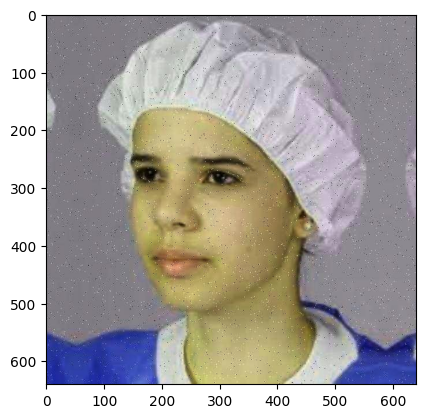

In [13]:
# Select one valid subset: train, test or valid
subset = "train"
images_path = os.path.join(CFG.DATASET_PATH, subset, "images")
images_list = os.listdir(images_path)
image_index = random.randint(0, len(images_list))

# Random image path
example_image_path = os.path.join(images_path, images_list[image_index])

# Plot example image
display_image(example_image_path)

**Visualization of many images**

In [14]:
# Display many images
def plot_random_images_from_folder(folder_path, num_images = 20, seed = 0):

  random.seed(seed)

  # Get a list of image files in the folder
  image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png", ".jpeg", ".gif"))]

  # Make sure that we have a least num_images files to choose from
  if len(image_files) < num_images:
    raise ValueError("Not enough images in the folder")

  # Randomly select num_images image files
  selected_files = random.sample(image_files, num_images)

  # Create a subplot grid
  num_cols = 5
  num_rows = (num_images + num_cols - 1) // num_cols
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,10))

  for i, file_name in enumerate(selected_files):
    # Open and display the image using PIL
    img = Image.open(os.path.join(folder_path, file_name))

    if num_rows == 1:
      ax = axes[i % num_cols]
    else:
      ax = axes[i // num_cols, i % num_cols]

    ax.imshow(img)
    # ax.axis("off")
    # ax.set_title(file_name)

  # Remove empty subplots
  for i in range(num_images, num_rows * num_cols):
    if num_rows == 1:
      fig.delaxes(axes[i % num_cols])
    else:
      fig.delaxes(axes[i // num_cols, i % num_cols])

  plt.tight_layout()
  plt.show()

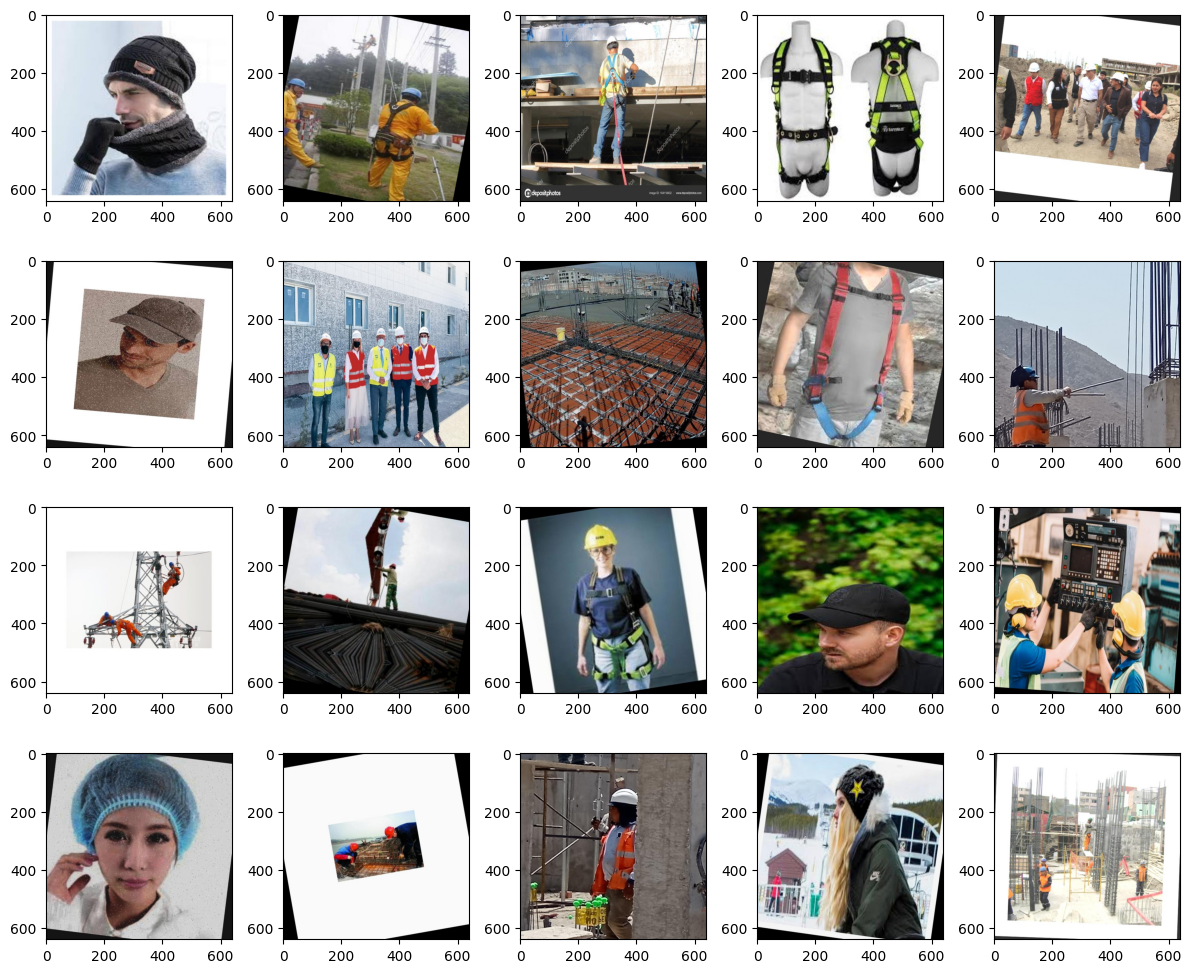

In [15]:
# Select one valis subset: train, test or valid
subset = "train"
images_path = os.path.join(CFG.DATASET_PATH, subset, "images")
plot_random_images_from_folder(images_path, num_images=20)

**Dataset statistics**

In [16]:
# Classes
class_idx = {str(i): CFG.CLASSES[i] for i in range(len(CFG.CLASSES))}
class_stat = {}
data_len = {}
class_info = []

for subset in ["train", "valid", "test"]:
  class_count = {CFG.CLASSES[i]: 0 for i in range(len(CFG.CLASSES))}

  labels_path = os.path.join(CFG.DATASET_PATH, subset, "labels")
  for file in os.listdir(labels_path):
    with open(os.path.join(labels_path, file)) as f:
      lines = f.readlines()

      for cls in [line[0] for line in lines]:
        class_count[class_idx[cls]] += 1

    f.close()

  data_len[subset] = len(os.listdir(labels_path))
  class_stat[subset] = class_count

  class_info.append({"Subset": subset, **class_count, "Data_Volume": data_len[subset]})

# Convert class info list to pandas dataframe
dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

,Subset,hard_hat,no_hard_hat,no_safety_harness,no_safety_vest,person,safety_harness,safety_vest,Data_Volume
0,train,20149,7204,8276,15615,23450,2868,7620,10497
1,valid,1875,868,895,1578,2347,268,769,1001
2,test,1045,411,454,785,1174,124,395,500


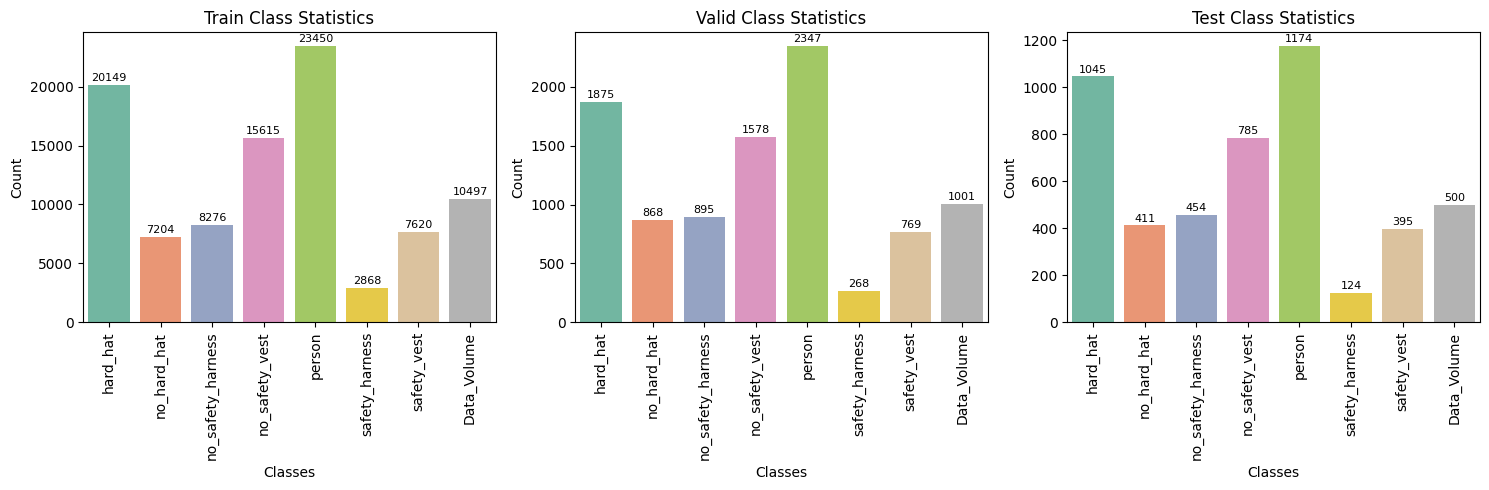

In [17]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(["train", "valid", "test"]):
  sns.barplot(
    data = dataset_stats_df[dataset_stats_df["Subset"] == mode].drop(columns="Subset"),
    orient="v",
    ax = axes[i],
    palette = "Set2"
  )

  axes[i].set_title(f"{mode.capitalize()} Class Statistics")
  axes[i].set_xlabel("Classes")
  axes[i].set_ylabel("Count")
  axes[i].tick_params(axis = "x", rotation = 90)

  # Add annotations on top of each bar
  for p in axes[i].patches:
    axes[i].annotate(f"{int(p.get_height())}",
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = "center",
                      va = "center",
                      fontsize = 8,
                      color = "black",
                      xytext = (0,5),
                      textcoords = "offset points"
                    )

plt.tight_layout()
plt.show()

**Image size**

In [18]:
for mode in ["train", "valid", "test"]:
  print(f"\nImage size in {mode} set:")

  img_size = 0

  for file in glob.glob(os.path.join(CFG.DATASET_PATH, mode, "images", "*")):

    image = Image.open(file)

    if image.size != img_size:
      print(f"{image.size}")
      img_size = image.size


Image size in train set:
(640, 640)

Image size in valid set:
(640, 640)

Image size in test set:
(640, 640)


## **TRAIN YOLOv8**

**Download the base model**

In [7]:
# Donwload base model function
def donwload_base_model(base_model = "yolov8n.pt"):
  base_models_dir_path = os.path.join(MODELS_DIR, "base")
  os.makedirs(base_models_dir_path, exist_ok=True)

  model_file = os.path.join(base_models_dir_path, base_model)
  # Model from yaml file
  if "yaml" in base_model:
    model_file = base_model
    print(f"Empty {model_file} was charged.")

  # Model from pt file
  else:
    if base_model not in os.listdir(base_models_dir_path):
      print(f"Downloading {base_model} ...")
      try:
        urllib.request.urlretrieve(f"https://github.com/ultralytics/assets/releases/download/v8.2.0/{base_model}", model_file)
        print(f"The model {base_model} was downloaded.")
      except:
        print(f"Something went wrong with downloading ...")
    else:
      print(f"The model {base_model} already exists.")

# Download the base model
donwload_base_model(base_model=CFG.BASE_MODEL)

The model yolov8n.pt already exists.


**Verify the dataset**

In [8]:
# Get the dataset yaml file
train_dataset = verify_dataset(CFG.DATASET_PATH, CFG.DATASET_YAML_PATH)

 INFO: The dataset exists. 

names:
- hard_hat
- no_hard_hat
- no_safety_harness
- no_safety_vest
- person
- safety_harness
- safety_vest
nc: 7
roboflow:
  license: CC BY 4.0
  project: yolo_ppe_detection
  url: https://universe.roboflow.com/deeplearning-cwudo/yolo_ppe_detection/dataset/5
  version: 5
  workspace: deeplearning-cwudo
test: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/test/images
train: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/train/images
val: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/valid/images



**Verify the model**

In [9]:
if ".yaml" != os.path.splitext(CFG.TRAIN_MODEL_PATH)[1]:
  if not os.path.isfile(CFG.TRAIN_MODEL_PATH):
    print(f"\033[31m ERROR: Is posible the base model {CFG.TRAIN_MODEL_PATH} don't exist. \033[0m")
  else:
    print(f"\033[34m INFO: The base model {CFG.TRAIN_MODEL_PATH} exists. \033[0m")
else:
  print(f"\033[34m INFO: The base model {CFG.TRAIN_MODEL_PATH} is a YAML file. \033[0m")

 INFO: The base model /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/base/yolov8n.pt exists. 


**Train settings**

In [10]:
# Project configuration
train_path = os.path.join(CFG.TRAIN_PROJECT_PATH, CFG.TRAIN_NAME)
if os.path.isdir(train_path):
  shutil.rmtree(train_path)

print("Train model path:\t", CFG.TRAIN_MODEL_PATH)
print("Train project name:\t", CFG.TRAIN_PROJECT_NAME)
print("Train project path:\t", CFG.TRAIN_PROJECT_PATH)
print("Train name:\t", CFG.TRAIN_NAME)

Train model path:	 /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/base/yolov8n.pt
Train project name:	 train_yolov8n_ppe_detection_debug
Train project path:	 /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/train_yolov8n_ppe_detection_debug
Train name:	 pt_3_epochs


In [11]:
cfg_train = {
  "data": train_dataset,
  "epochs": CFG.EPOCHS,
  "time": None,
  "patience": CFG.PATIENCE,
  "batch": 16,
  "imgsz": 640,
  "save": True,
  "save_period": -1,
  "cache": False,
  "device": CFG.TRAIN_DEVICE,
  "project": CFG.TRAIN_PROJECT_PATH,
  "name": CFG.TRAIN_NAME,
  "exist_ok": False,
  "pretrained": True,
  "optimizer": "auto",
  "classes": None,
  "multi_scale": False,
  "close_mosaic": 10,
  "resume": False,
  "amp": True,
  "fraction": CFG.FRACTION,
  "profile": False,
  "freeze": None,
  "lr0": 0.01,
  "lrf": 0.01,
  "momentum": 0.937,
  "weight_decay": 0.0005,
  "warmup_epochs": 3.0,
  "warmup_momentum": 0.8,
  "warmup_bias_lr": 0.1,
  "box": 7.5,
  "cls": 0.5,
  "val": False,
  "iou": 0.8,
  "augment": False,
  "plots": True
}

for key, value in cfg_train.items():
    print(key, ":", value)

data : /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/data.yaml
epochs : 3
time : None
patience : 40
batch : 16
imgsz : 640
save : True
save_period : -1
cache : False
device : 0
project : /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/train_yolov8n_ppe_detection_debug
name : pt_3_epochs
exist_ok : False
pretrained : True
optimizer : auto
classes : None
multi_scale : False
close_mosaic : 10
resume : False
amp : True
fraction : 0.01
profile : False
freeze : None
lr0 : 0.01
lrf : 0.01
momentum : 0.937
weight_decay : 0.0005
warmup_epochs : 3.0
warmup_momentum : 0.8
warmup_bias_lr : 0.1
box : 7.5
cls : 0.5
val : False
iou : 0.8
augment : False
plots : True


**Comet ML configuration**

In [12]:
# Comet config
comet_ml.login()
experiment_config = comet_ml.ExperimentConfig(name=CFG.TRAIN_NAME)
exp = comet_ml.start(project_name=CFG.TRAIN_PROJECT_NAME, experiment_config=experiment_config)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/alexpfoccori/train-yolov8n-ppe-detection-debug/8aa9f76f398a4a9f86f9cff71fc6b0d1



**Load the model**

In [13]:
try:
  train_model = YOLO(CFG.TRAIN_MODEL_PATH)
  print(f"The {CFG.TRAIN_MODEL_PATH} was loaded.")
except:
  print(f"Error loading the {CFG.TRAIN_MODEL_PATH} model.")

The /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/base/yolov8n.pt was loaded.


**Model information**

In [14]:
train_model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

**Train model**

In [ ]:
train_results = train_model.train(**cfg_train)
exp.end()

New https://pypi.org/project/ultralytics/8.3.68 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4034MiB)
engine/trainer: task=detect, mode=train, model=/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/base/yolov8n.pt, data=/home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/data.yaml, epochs=3, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/train_yolov8n_ppe_detection_debug, name=pt_3_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.01, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_h

**Train results**

In [ ]:
print("map50-95", ":", train_results.box.map)
print("map50", ":", train_results.box.map50)
print("map75", ":", train_results.box.map75)
print("maps", ":", train_results.box.maps)

**Images of the train results**

In [ ]:
train_results_path = train_results.save_dir
train_image_files = [
  i for i in
  glob.glob(f"{train_results_path}/*.png") + glob.glob(f"{train_results_path}/*.jpg")
  if "batch" not in i
]

train_image_files

**Plot images of the train results**

In [ ]:
for image in sorted(train_image_files):
  image_name = image.split("/")[-1]
  print(image_name)

  img = Image.open(image)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

  print("\n")

**CSV results**

In [ ]:
df = pd.read_csv(f"{train_results_path}/results.csv")
df = df.rename(columns=lambda x: x.replace(" ", ""))
df

In [ ]:
print("*"*50)
print("\nBest Training Box loss: ", df["train/box_loss"].min(), ", on epoch: ", df["train/box_loss"].argmin() + 1)
print("\nBest Validation Box loss: ", df["val/box_loss"].min(), ", on epoch: ", df["val/box_loss"].argmin() + 1, "\n")

print("="*50)
print("\nBest Training Cls loss: ", df["train/cls_loss"].min(), ", on epoch: ", df["train/cls_loss"].argmin() + 1)
print("\nBest Validation Cls loss: ", df["val/cls_loss"].min(), ", on epoch: ", df["val/cls_loss"].argmin() + 1, "\n")

print("="*50)
print("\nBest Training DFL loss: ", df["train/dfl_loss"].min(), ", on epoch: ", df["train/dfl_loss"].argmin() + 1)
print("\nBest Validation DFL loss: ", df["val/dfl_loss"].min(), ", on epoch: ", df["val/dfl_loss"].argmin() + 1, "\n")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

#Training and Validation box_loss
ax1.set_title("Box Loss")
ax1.plot(df["epoch"], df["train/box_loss"], label="Training box_loss", marker="o", linestyle="-")
ax1.plot(df["epoch"], df["val/box_loss"], label="Validation box_loss", marker="o", linestyle="-")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Box Loss")
ax1.legend()
ax1.grid(True)

# Training and Validation cls_loss
ax2.set_title("Cls Loss")
ax2.plot(df["epoch"], df["train/cls_loss"], label="Training cls_loss", marker="o", linestyle="-")
ax2.plot(df["epoch"], df["val/cls_loss"], label="Validation cls_loss", marker="o", linestyle="-")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Cls loss")
ax2.legend()
ax2.grid(True)

# Training and Validation dfl_loss
ax3.set_title("DFL Loss")
ax3.plot(df["epoch"], df["train/dfl_loss"], label="Training dfl_loss", marker="o", linestyle="-")
ax3.plot(df["epoch"], df["val/dfl_loss"], label="Validation dfl_loss", marker="o", linestyle="-")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("DFL loss")
ax3.legend()
ax3.grid(True)

plt.suptitle("Training Metrics vs. Epochs")
plt.show()

**Validation results**

In [ ]:
train_results_path = train_results.save_dir
valid_image_files = [
  i for i in
  glob.glob(f"{train_results_path}/*.png") + glob.glob(f"{train_results_path}/*.jpg")
  if "val_batch" in i
]

valid_image_files

**Plot images of the validation results**

In [ ]:
for image in sorted(valid_image_files):
  image_name = image.split("/")[-1]
  print(image_name)

  img = Image.open(image)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

  print("\n")

## **VALID YOLOv8**

**Verify the dataset**

In [ ]:
# Get the dataset yaml file
valid_dataset = verify_dataset(CFG.DATASET_PATH)

**Verify the model**

In [ ]:
if not os.path.isfile(CFG.VALID_MODEL_PATH):
  print(f"\033[31m ERROR: Is posible the trained model {CFG.VALID_MODEL_PATH} don't exist. \033[0m")
else:
  print(f"\033[34m INFO: The trained model {CFG.VALID_MODEL_PATH} exists. \033[0m")

**Validation settings**

In [ ]:
# Project configuration
valid_path = os.path.join(CFG.VALID_PROJECT_PATH, CFG.VALID_NAME)
if os.path.isdir(valid_path):
    shutil.rmtree(valid_path)

print("Valid model path:\t", CFG.VALID_MODEL_PATH)
print("Valid project name:\t", CFG.VALID_PROJECT_NAME)
print("Valid project path:\t", CFG.VALID_PROJECT_PATH)
print("Valid name:\t", CFG.VALID_NAME)

In [ ]:
cfg_valid = {
  "data": valid_dataset,
  "imgsz": 640,
  "batch": 64,
  "save_json": True,
  "save_hybrid": False,
  "conf": 0.001,
  "iou": 0.8,
  "half": True,
  "device": CFG.VALID_DEVICE,
  "plots": True,
  "rect": True,
  "split": "val",
  "project": CFG.VALID_PROJECT_PATH,
  "name": CFG.VALID_NAME
}

for key, value in cfg_valid.items():
  print(key, ":", value)

**Load the model**

In [ ]:
try:
  valid_model = YOLO(CFG.VALID_MODEL_PATH)
  print(f"The {CFG.VALID_MODEL_PATH} was loaded.")
except:
  print(f"Error loading the {CFG.VALID_MODEL_PATH} model.")

**Model information**

In [ ]:
valid_model.info()

**Validate model**

In [ ]:
valid_metrics = valid_model.val(**cfg_valid)

**Valid metrics**

In [ ]:
print("map50-95", ":", valid_metrics.box.map)
print("map50", ":", valid_metrics.box.map50)
print("map75", ":", valid_metrics.box.map75)
print("maps", ":", valid_metrics.box.maps)

**Images of the metrics and validation**

In [ ]:
valid_metrics_path = valid_metrics.save_dir
valid_image_files = [
  i for i in
  glob.glob(f"{valid_metrics_path}/*.png") + glob.glob(f"{valid_metrics_path}/*.jpg")
]

valid_image_files

**Plot images of the results**

In [ ]:
for image in sorted(valid_image_files):
  image_name = image.split("/")[-1]
  print(image_name)

  img = Image.open(image)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

  print("\n")

## **EXPORT YOLOv8**

**Verify dataset**

In [ ]:
# Get the dataset yaml file
export_dataset = verify_dataset(CFG.DATASET_PATH)

**Copy trained model and verify**

In [ ]:
if not os.path.isfile(CFG.VALID_MODEL_PATH):
  print(f"\033[31m ERROR: Is posible the trained model {CFG.VALID_MODEL_PATH} don't exist. \033[0m")
else:
  shutil.copy(CFG.VALID_MODEL_PATH, CFG.EXPORT_MODEL_PATH)
  print(f"\033[34m INFO: The trained model from {CFG.VALID_MODEL_PATH} was copied to {CFG.EXPORT_MODEL_PATH}. \033[0m")

**Export settings**

In [ ]:
export_args = [
  "format",
  "imgsz",
  "keras",
  "optimize",
  "half",
  "int8",
  "dynamic",
  "simplify",
  "opset",
  "workspace",
  "nms",
  "batch",
  "device",
  "name",
  "data"
]

format_args = {
  "torchscript": [1, 3, 11],
  "onnx": [1, 4, 6, 7, 8, 11],
  "openvino": [1, 4, 5, 6, 11],
  "engine": [1, 4, 5, 6, 7, 9, 11, 14],
  "coreml": [1, 4, 5, 10, 11],
  "saved_model": [1, 2, 5, 11],
  "pb": [1, 11],
  "tflite": [1, 4, 5, 11],
  "edgetpu": [1],
  "tfjs": [1, 4, 5, 11],
  "paddle": [1, 11],
  "mnn": [1, 4, 5, 11],
  "ncnn": [1, 4, 11],
  "imx": [1, 5],
  "rknn": [1, 11, 13]
}

print(f"\033[34m INFO: Export in {CFG.EXPORT_FORMAT} format, change the next arguments. \033[0m")
id_args = format_args[CFG.EXPORT_FORMAT]
for id_arg in id_args:
  print(f"\033[34m\t {export_args[id_arg]} \033[0m")

In [ ]:
cfg_export = {
  "format": CFG.EXPORT_FORMAT,
  "imgsz": 640,
  #"keras": False,
  #"optimize": False,
  "half": False,
  "int8": False,
  "dynamic": True,
  "simplify": True,
  #"opset": None,
  "workspace": 4,
  #"nms": False,
  "batch": 1,
  "device": CFG.EXPORT_DEVICE,
  "name": None,
  "data": export_dataset
}

for key, value in cfg_export.items():
  print(key, ":", value)

**Load the model**

In [ ]:
try:
  export_model = YOLO(CFG.EXPORT_MODEL_PATH)
  print(f"The {CFG.EXPORT_MODEL_PATH} was loaded.")
except:
  print(f"Error loading the {CFG.EXPORT_MODEL_PATH} model.")

**Export model**

In [ ]:
export_model.export(**cfg_export)

## **PREDICT YOLOv8**

**Verify the model**

In [ ]:
if not os.path.isfile(CFG.PREDICT_MODEL_PATH):
  print(f"\033[31m ERROR: Is posible the prediction model {CFG.PREDICT_MODEL_PATH} don't exist. \033[0m")
else:
  print(f"\033[34m INFO: The prediction model {CFG.PREDICT_MODEL_PATH} exists. \033[0m")

**Predict settings**

In [ ]:
# Project configuration
print("Predict model path:\t", CFG.PREDICT_MODEL_PATH)
print("Predict project name:\t", CFG.PREDICT_PROJECT_NAME)
print("Predict project path:\t", CFG.PREDICT_PROJECT_PATH)
print("Predict name:\t", CFG.PREDICT_NAME)

In [ ]:
cfg_predict = {
  # Inference arguments
  "source": "https://www.cdc.gov/niosh/media/images/CONaerialviewthumb.jpg",
  "stream": False,
  "conf": 0.1,
  "iou": 0.5,
  "imgsz": 640,
  "half": False,
  "device": CFG.PREDICT_DEVICE,
  "vid_stride": 1,
  "stream_buffer": False,
  "visualize": False,
  "augment": False,
  "agnostic_nms": False,
  "classes": [0],
  "project": CFG.PREDICT_PROJECT_PATH,
  "name": CFG.PREDICT_NAME,

  # Visualization arguments
  "show": False,
  "save": True,
  "save_frames": False,
  "save_txt": False,
  "save_conf": False,
  "save_crop": False,
  "show_labels": True,
  "show_conf": True,
  "show_boxes": True,
  "line_width": None
}

for key, value in cfg_predict.items():
  print(key, ":", value)

**Load the model**

In [ ]:
try:
  predict_model = YOLO(CFG.PREDICT_MODEL_PATH, task="detect")
  print(f"The {CFG.PREDICT_MODEL_PATH} was loaded.")
except:
  print(f"Error loading the {CFG.PREDICT_MODEL_PATH} model.")

**Predict model**

In [ ]:
predict_results = predict_model(**cfg_predict)

**Prediction results**

In [ ]:
for result in predict_results:
    print("Original Image path", ":", result.path)
    print("Result Image path", ":", os.path.join(result.save_dir, result.path.split("/")[-1]))
    for key, value in result.names.items():
        print(value, ":", result.boxes.cls.cpu().tolist().count(key)) if key in result.boxes.cls else None
    orig_img = Image.open(result.path)
    pred_img = Image.open(os.path.join(result.save_dir, result.path.split("/")[-1]))
    plt.imshow(pred_img)
    plt.axis("off")
plt.show()